# Hemophilia A - Rapid visualization and analysis of hemophilia databases


## Installing matplotlib 3.4

In [ ]:
!pip install --upgrade matplotlib==3.4 # restart environment after execute

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Import

In [ ]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
from collections import defaultdict
from matplotlib import pyplot as plt

## Preprocessing

The position graph allowed to identify inconsistencies in the dataset that were modified manually before the analysis.
* Domain A1 changed to A2 
  * p.Leu417
  * p.Pro54Glnfs*18
* Domain A4 changed to A3
  * p.Glu1894Val
* Domain C1 changed to C2
  * p.Pro2224Arg



### Raw dataframe

In [ ]:
df_original = pd.read_excel('champ-mutation-list-q4-clean.xlsx', index_col=0)
df_original.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1776 entries, 0 to 1775
Data columns (total 25 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   HGVS cDNA                      1776 non-null   object 
 1   hg19 Coordinates               1776 non-null   object 
 2   HGVS Protein                   1776 non-null   object 
 3   Mature Protein                 1776 non-null   object 
 4   Mutation Type                  1776 non-null   object 
 5   Mechanism                      1776 non-null   object 
 6   Exon                           1776 non-null   int64  
 7   Codon                          1776 non-null   int64  
 8   Domain                         1776 non-null   object 
 9   Subtype                        1776 non-null   object 
 10  In Poly A                      1776 non-null   object 
 11  Severe (<1 U/dL)               644 non-null    object 
 12  Moderate (1-5 U/dL)            301 non-null    o

### Clean dataframe

In [ ]:
def set_column_categorical(df, column):
    df[column] = pd.Categorical(df[column], ordered=True)

def set_column_capitalize(df, column):
    df[column] = df[column].apply(lambda s: s.capitalize())

In [ ]:
df = df_original.copy()

# getting only mutations with reported severity found
df = df[df['Reported Severity'] != 'Not Reported']

# setting columns as categorical type to order it
set_column_categorical(df, 'Reported Severity')
set_column_categorical(df, 'Mutation Type')
set_column_categorical(df, 'Mechanism')
set_column_categorical(df, 'History of Inhibitor')
df['Domain'] = pd.Categorical(df['Domain'], ['Signal', 'A1', 'a1', 'A2', 'a2', 'B', 'a3', 'A3', 'C1', 'C2'])

### No dupes dataframe

In [ ]:
df_no_dup = df.copy()

# remove rows based on position > no duplicated mutations
df_no_dup.drop_duplicates(subset='HGVS Position', keep='first', inplace=True)

df_no_dup.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 817 entries, 0 to 1771
Data columns (total 25 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   HGVS cDNA                      817 non-null    object  
 1   hg19 Coordinates               817 non-null    object  
 2   HGVS Protein                   817 non-null    object  
 3   Mature Protein                 817 non-null    object  
 4   Mutation Type                  817 non-null    category
 5   Mechanism                      817 non-null    category
 6   Exon                           817 non-null    int64   
 7   Codon                          817 non-null    int64   
 8   Domain                         817 non-null    category
 9   Subtype                        817 non-null    object  
 10  In Poly A                      817 non-null    object  
 11  Severe (<1 U/dL)               279 non-null    object  
 12  Moderate (1-5 U/dL)            140 

## Pre-analysis

### Choose colors

In [ ]:
choose_color = defaultdict(lambda: 'tab:blue')

choose_color['No'] = 'tab:green'
choose_color['No - Inhibitor'] = 'tab:green'
choose_color['Mild'] = 'tab:green'

choose_color['Moderate'] = 'tab:orange'

choose_color['Yes'] = 'tab:red'
choose_color['Yes - Inhibitor'] = 'tab:red'
choose_color['Severe'] = 'tab:red'

### Choose dataframe

In [ ]:
def choose_df(has_dup, column=None, choice=None):
    if column == None and choice == None:
        return df if has_dup else df_no_dup
    elif choice == None:
        return df[column] if has_dup else df_no_dup[column]
    else:  
        if has_dup:
            return df[df[column] == choice]
        else:
            return df_no_dup[df_no_dup[column] == choice]

### Choose title

In [ ]:
def choose_title(has_dup, column, choice):
    dup = 'WITH dup mutations' if has_dup else 'WITHOUT dup mutations'
    if column == None and choice == None:
        return f'\n{dup}'
    elif choice == None:
        return f' - {column}\n{dup}'
    else:
        return f' - {column} = {choice}\n{dup}'

### Verify Count

In [ ]:
def verify_count(info, has_dup, column=None, choice=None):
    df_aux = choose_df(has_dup, column, choice).copy()
    df_aux = df_aux.groupby([info])[info].count()
    print(f'{choose_title(has_dup, column, choice)}\n\n{df_aux}')

### Catplot

In [ ]:
def catplot_custom(x, hue, has_dup, column=None, choice=None):
    ax = sns.catplot(
        data = choose_df(has_dup, column, choice),
        x = x, 
        hue = hue,
        kind = 'count',
        height = 5,
        aspect = 1.7
    )

    ax.set(
        title =f'{x}{choose_title(has_dup, column, choice)}'.center(30),
        xlabel = None,
        ylabel = 'Number of cases',
    )

    # plt.savefig(f'catplot.svg')
    plt.show()
    print()

### Histplot - Position

In [ ]:
def histplot_position(hue, div, has_dup, column=None, choice=None):
    sns.set(rc = {'figure.figsize' : (25, 5)})

    palette = dict(Severe = 'r', Moderate = 'y', Mild = 'g') if hue == 'Reported Severity' else 'viridis'

    ax = sns.histplot(
        data = choose_df(has_dup, column, choice), 
        x = 'HGVS Position',
        bins = int(df['HGVS Position'].max() // div),
        multiple = 'stack',
        hue = hue,
        palette = palette,
    )
  
    ax.set(
        title = f'{hue} per Position{choose_title(has_dup, column, choice)}'.center(30),
        ylabel = 'Number of cases',
    )

    # plt.savefig(f'histplot_position.svg')
    plt.show()
    print()

### Histplot - One information

In [ ]:
XSIZE, YSIZE = 8, 5

In [ ]:
def count_above_bars(ax, df, info):
    # count using total info and percentage
    def count_from_percent(df, rectangle, info):
        count = rectangle.get_width()/100 * len(df[info])
        return int(round(count, 0))

    # getting counts based on percentage
    counts = [count_from_percent(df, rectangle, info) for rectangle in ax.containers[0]]

    # number above bar
    texts = ax.bar_label(ax.containers[0])
    for i in range(len(texts)):
        texts[i].set_text(f'{counts[i]}')

In [ ]:
def histplot_one_info(ax, y, has_dup, column=None, choice=None):
    sns.set(rc = {'figure.figsize' : (XSIZE, YSIZE)})
  
    sns.histplot(
        ax = ax,
        data = choose_df(has_dup, column, choice),
        y = y,
        stat = 'percent',
        color = choose_color[choice],
        # shrink = 0.75,
        )

    ax.set(
        title = f'{y}{choose_title(has_dup, column, choice)}'.center(30),
        xlabel = 'Percent of total [%]', 
        ylabel = None,
        xlim = [0, 100]
    )
  
    # set count above bars based on percentage
    count_above_bars(ax, choose_df(has_dup, column, choice), y)

    # plt.savefig(f'histplot_one_info.svg')
    # plt.show();

### Histplot - Two informations

In [ ]:
def histplot_two_info(ax, x, y, has_dup, column=None, choice=None):
    sns.set(rc = {'figure.figsize' : (XSIZE, YSIZE)})

    sns.histplot(
        ax = ax,
        data = choose_df(has_dup, column, choice),
        x = x,
        y = y,
        color = choose_color[choice],
    )

    ax.set(
        title = f'{x} vs {y}{choose_title(has_dup, column, choice)}'.center(30),
        xlabel = None, 
        ylabel = None,
    )

    # plt.savefig(f'histplot_two_info.svg')
    # plt.show()
    # print()

### Histplot - Extra

In [ ]:
def histplot_extra(ax, y, hue, has_dup, column=None, choice=None):
    sns.set(rc = {'figure.figsize' : (XSIZE, YSIZE)})

    sns.histplot(
        ax = ax,
        data = choose_df(has_dup, column, choice),
        y = y,
        stat = 'percent',
        multiple = 'stack',
        hue = hue,
        palette = choose_color,
    )

    ax.set(
        title = f'{y}{choose_title(has_dup, column, choice)}'.center(30),
        ylabel = None,
        xlabel = 'Percent of total [%]',
        xlim = [0, 100]
    )

    # plt.savefig(f'histplot_extra.svg')
    # plt.show()
    # print()

### Histplot - All

In [ ]:
XSIZE, YSIZE = 15, 15

In [ ]:
def histplot_one_all(y, column):
    fig, axes = plt.subplots(3, 2, figsize=(XSIZE, YSIZE), sharex=True, sharey=True)
    if column == 'Reported Severity':
        choices = ['Mild', 'Mild', 'Moderate', 'Moderate', 'Severe', 'Severe']
    elif column == 'History of Inhibitor':
        choices = ['No', 'No', 'Not Reported', 'Not Reported', 'Yes', 'Yes']
    
    histplot_one_info(axes[0, 0], y=y, has_dup=True, column=column, choice=choices[0])
    histplot_one_info(axes[0, 1], y=y, has_dup=False, column=column, choice=choices[1])
    histplot_one_info(axes[1, 0], y=y, has_dup=True, column=column, choice=choices[2])
    histplot_one_info(axes[1, 1], y=y, has_dup=False, column=column, choice=choices[3])
    histplot_one_info(axes[2, 0], y=y, has_dup=True, column=column, choice=choices[4])
    histplot_one_info(axes[2, 1], y=y, has_dup=False, column=column, choice=choices[5])
    plt.show()

    print('\n\n-------------------------------------------------------------\n')

    fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharex=True, sharey=True)
    histplot_extra(axes[0], y=y, hue=column, has_dup=True)
    histplot_extra(axes[1], y=y, hue=column, has_dup=False)
    plt.show()

In [ ]:
def histplot_two_all(x, y, column):
    fig, axes = plt.subplots(3, 2, figsize=(XSIZE, YSIZE), sharex=True, sharey=True)
    if column == 'Reported Severity':
        choices = ['Mild', 'Mild', 'Moderate', 'Moderate', 'Severe', 'Severe']
    elif column == 'History of Inhibitor':
        choices = ['No', 'No', 'Not Reported', 'Not Reported', 'Yes', 'Yes']
    
    histplot_two_info(axes[0, 0], x=x, y=y, has_dup=True, column=column, choice=choices[0])
    histplot_two_info(axes[0, 1], x=x, y=y, has_dup=False, column=column, choice=choices[1])
    histplot_two_info(axes[1, 0], x=x, y=y, has_dup=True, column=column, choice=choices[2])
    histplot_two_info(axes[1, 1], x=x, y=y, has_dup=False, column=column, choice=choices[3])
    histplot_two_info(axes[2, 0], x=x, y=y, has_dup=True, column=column, choice=choices[4])
    histplot_two_info(axes[2, 1], x=x, y=y, has_dup=False, column=column, choice=choices[5])
    plt.show()

## Analysis

### Position

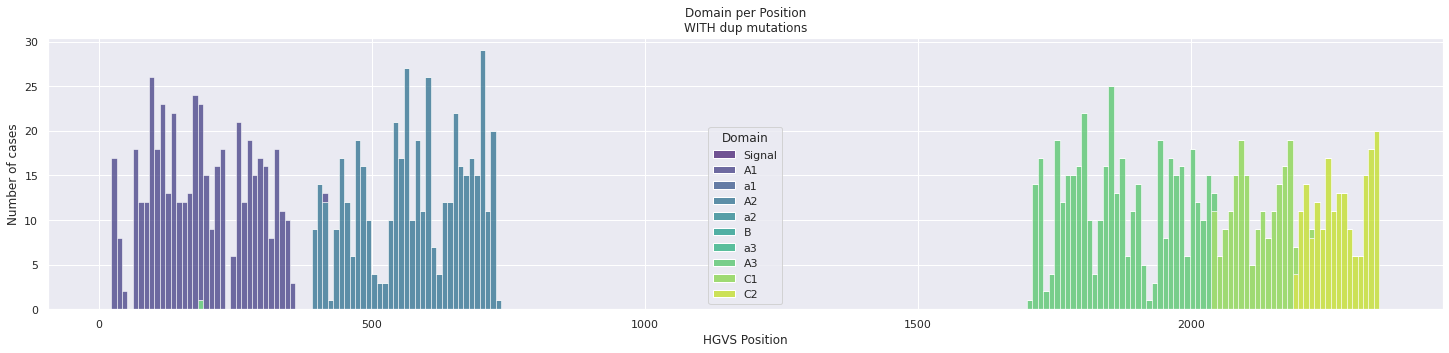

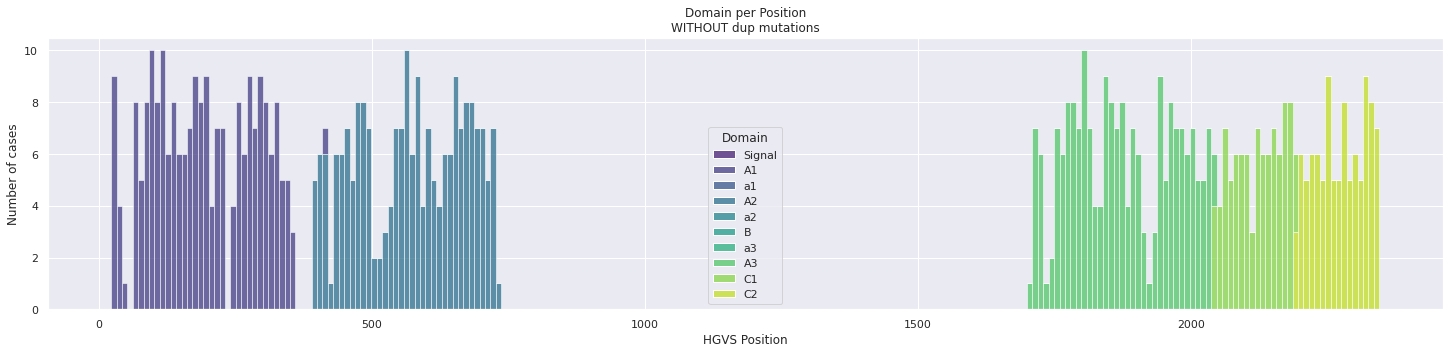

In [ ]:
histplot_position(hue='Domain', div=10, has_dup=True)
histplot_position(hue='Domain', div=10, has_dup=False)

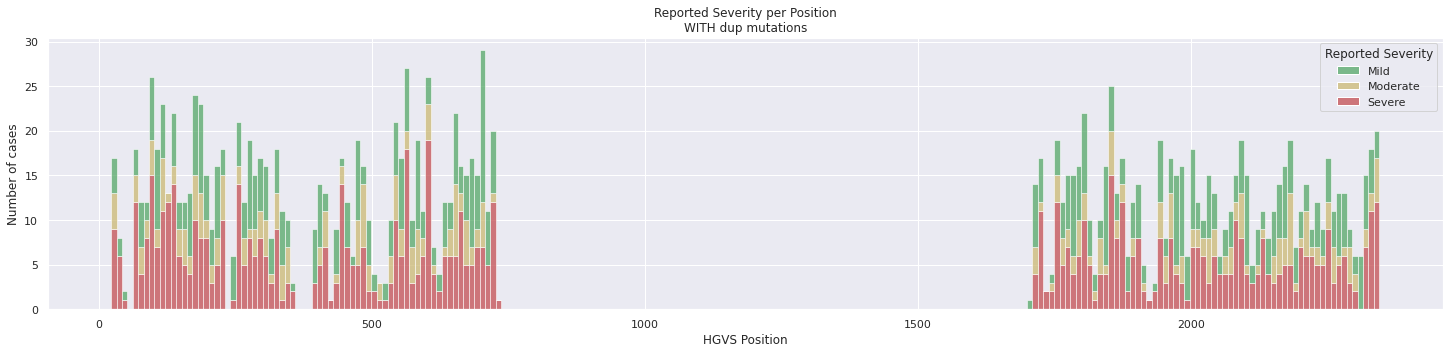

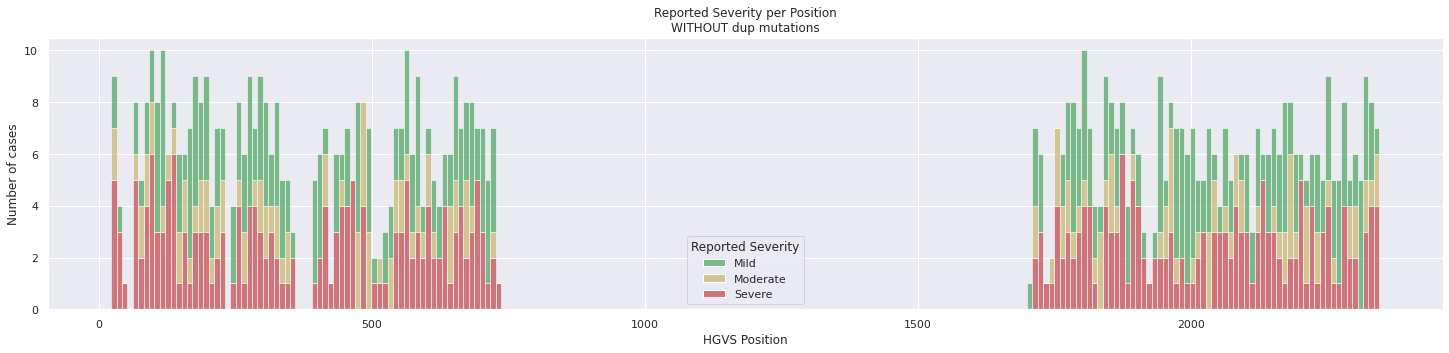

In [ ]:
histplot_position(hue='Reported Severity', div=10, has_dup=True)
histplot_position(hue='Reported Severity', div=10, has_dup=False)

### Mutation Type

In [ ]:
# verify count once and compare with graphic
verify_count(info='Mutation Type', has_dup=True)
verify_count(info='Mutation Type', has_dup=False)


WITH dup mutations

Mutation Type
Frameshift                                      28
Missense                                      1453
Nonsense                                       221
Small Structural Change (In-Frame, <50 Bp)       4
Splice Site Change                               1
Name: Mutation Type, dtype: int64

WITHOUT dup mutations

Mutation Type
Frameshift                                     11
Missense                                      697
Nonsense                                      107
Small Structural Change (In-Frame, <50 Bp)      2
Splice Site Change                              0
Name: Mutation Type, dtype: int64


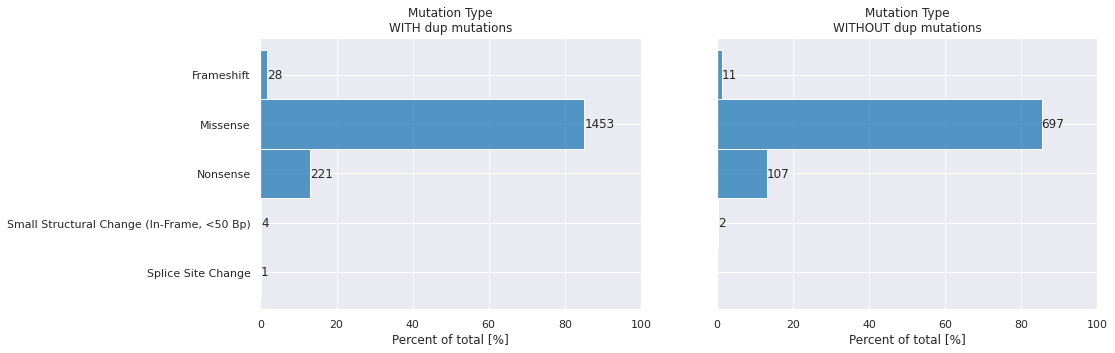

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
histplot_one_info(axes[0], y='Mutation Type', has_dup=True)
histplot_one_info(axes[1], y='Mutation Type', has_dup=False)


### Mechanism

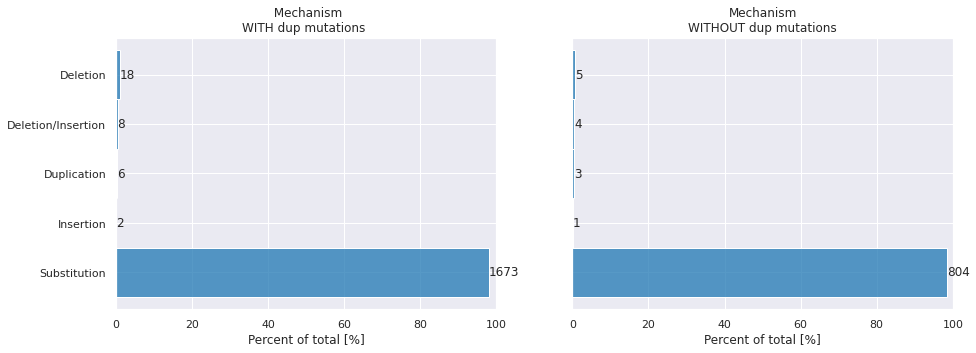

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
histplot_one_info(axes[0], y='Mechanism', has_dup=True)
histplot_one_info(axes[1], y='Mechanism', has_dup=False)

### Domain

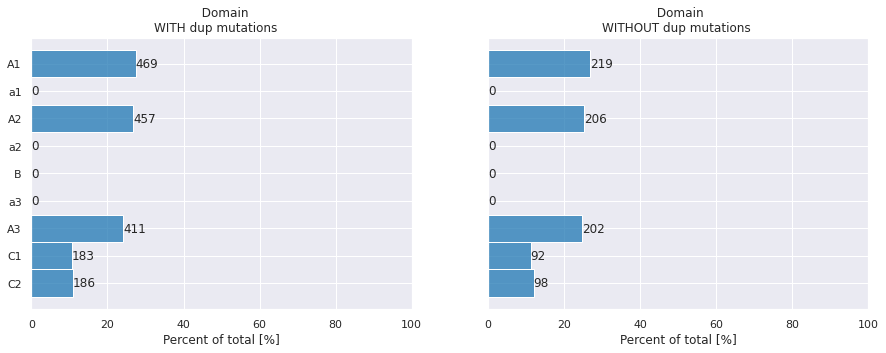

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
histplot_one_info(axes[0], y='Domain', has_dup=True)
histplot_one_info(axes[1], y='Domain', has_dup=False)

### Severity vs Mutation Type

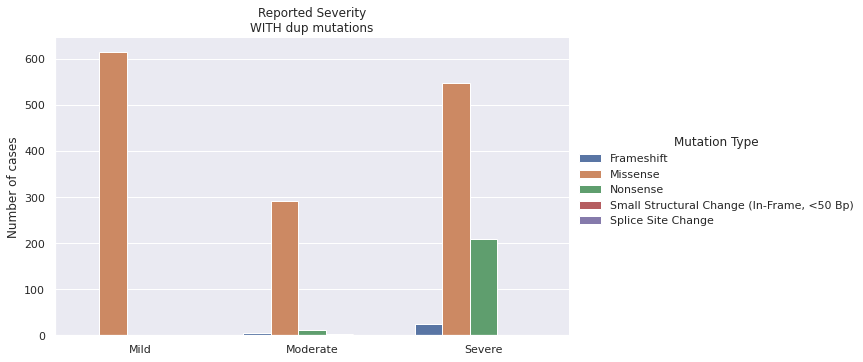

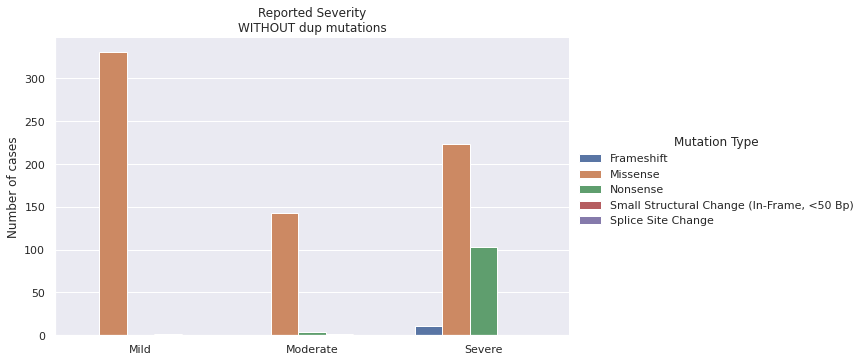

In [ ]:
catplot_custom(x='Reported Severity', hue='Mutation Type', has_dup=True)
catplot_custom(x='Reported Severity', hue='Mutation Type', has_dup=False)

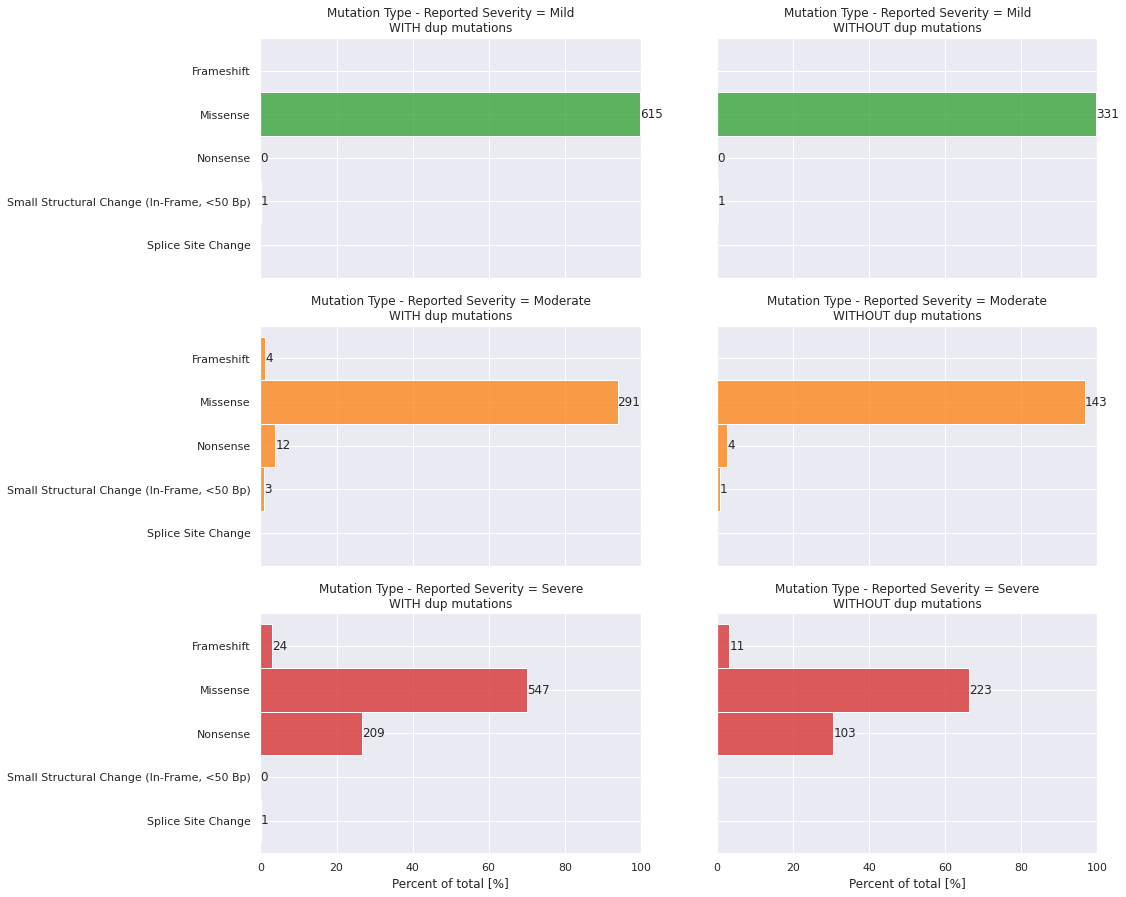



-------------------------------------------------------------



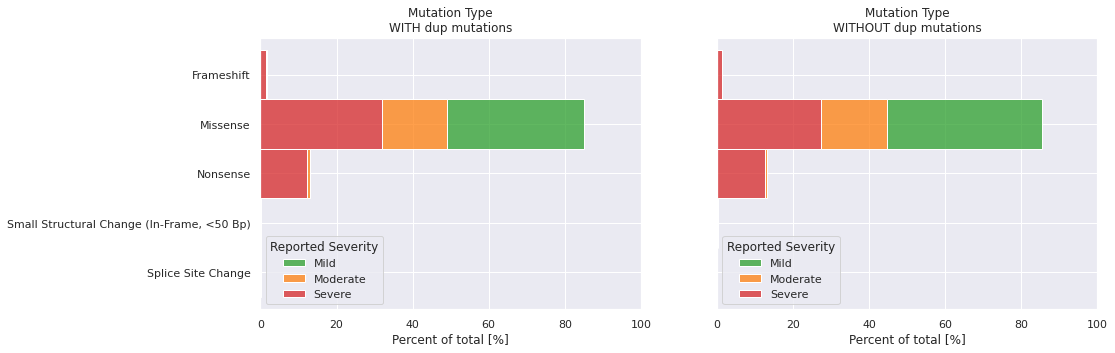

In [ ]:
histplot_one_all('Mutation Type', 'Reported Severity')

### Severity vs Mechanism

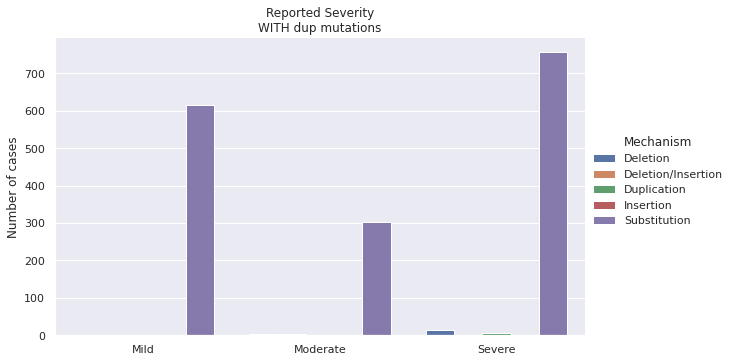

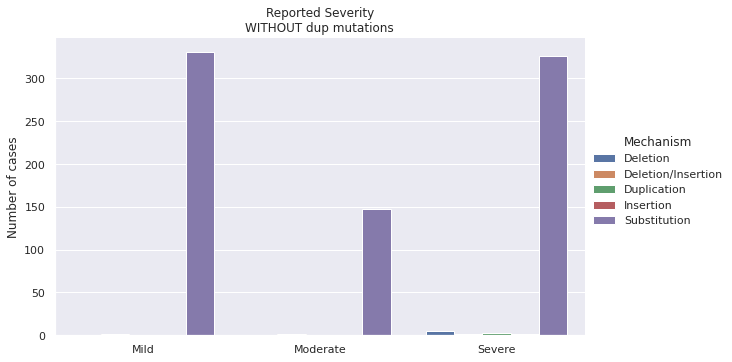

In [ ]:
catplot_custom(x='Reported Severity', hue='Mechanism', has_dup=True)
catplot_custom(x='Reported Severity', hue='Mechanism', has_dup=False)

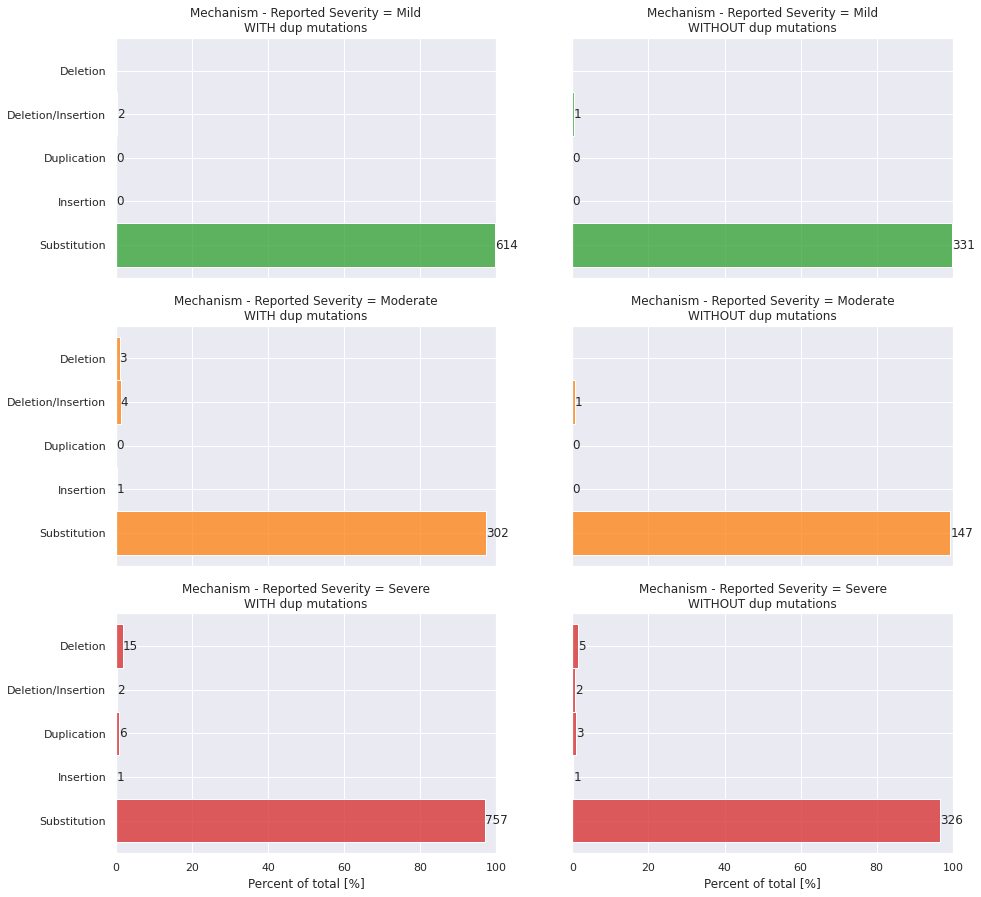



-------------------------------------------------------------



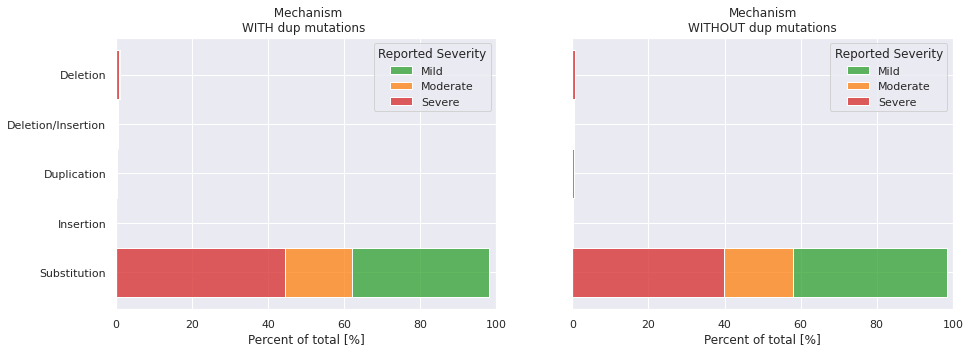

In [ ]:
histplot_one_all('Mechanism', 'Reported Severity')

### Severity vs Domain

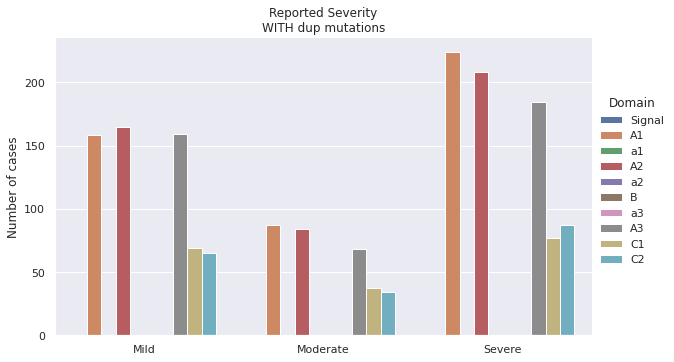

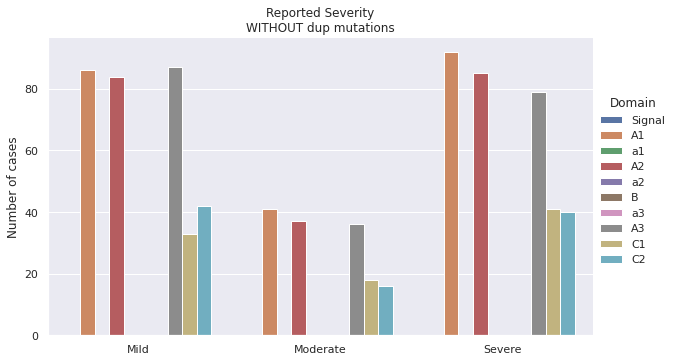

In [ ]:
catplot_custom(x='Reported Severity', hue='Domain', has_dup=True)
catplot_custom(x='Reported Severity', hue='Domain', has_dup=False)

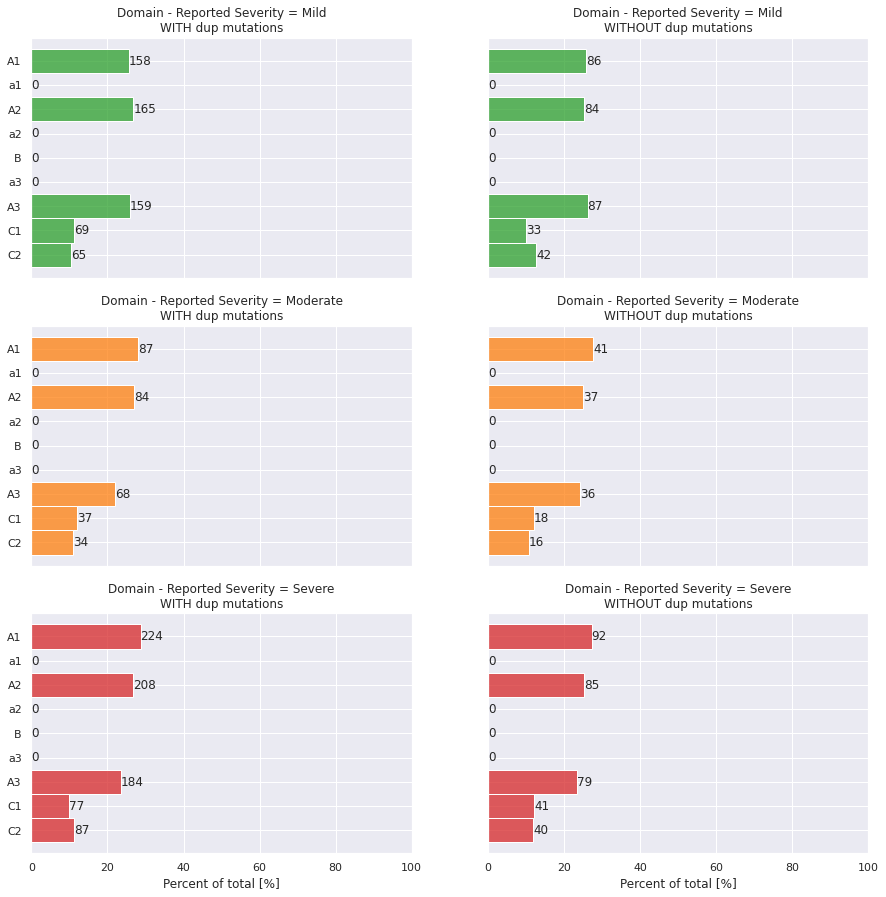



-------------------------------------------------------------



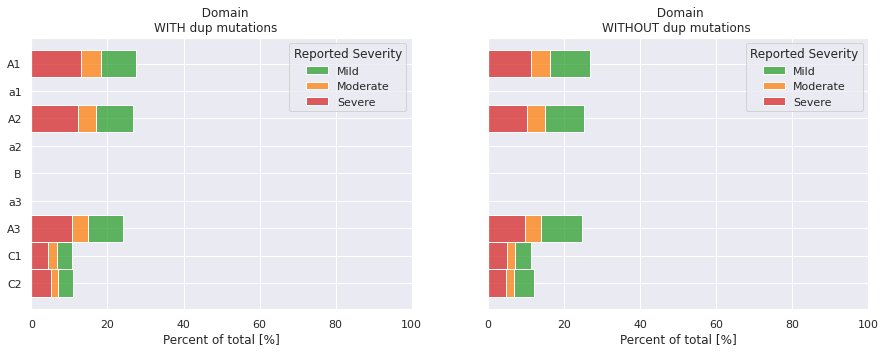

In [ ]:
histplot_one_all('Domain', 'Reported Severity')

### Severity vs Domain vs Mutation Type

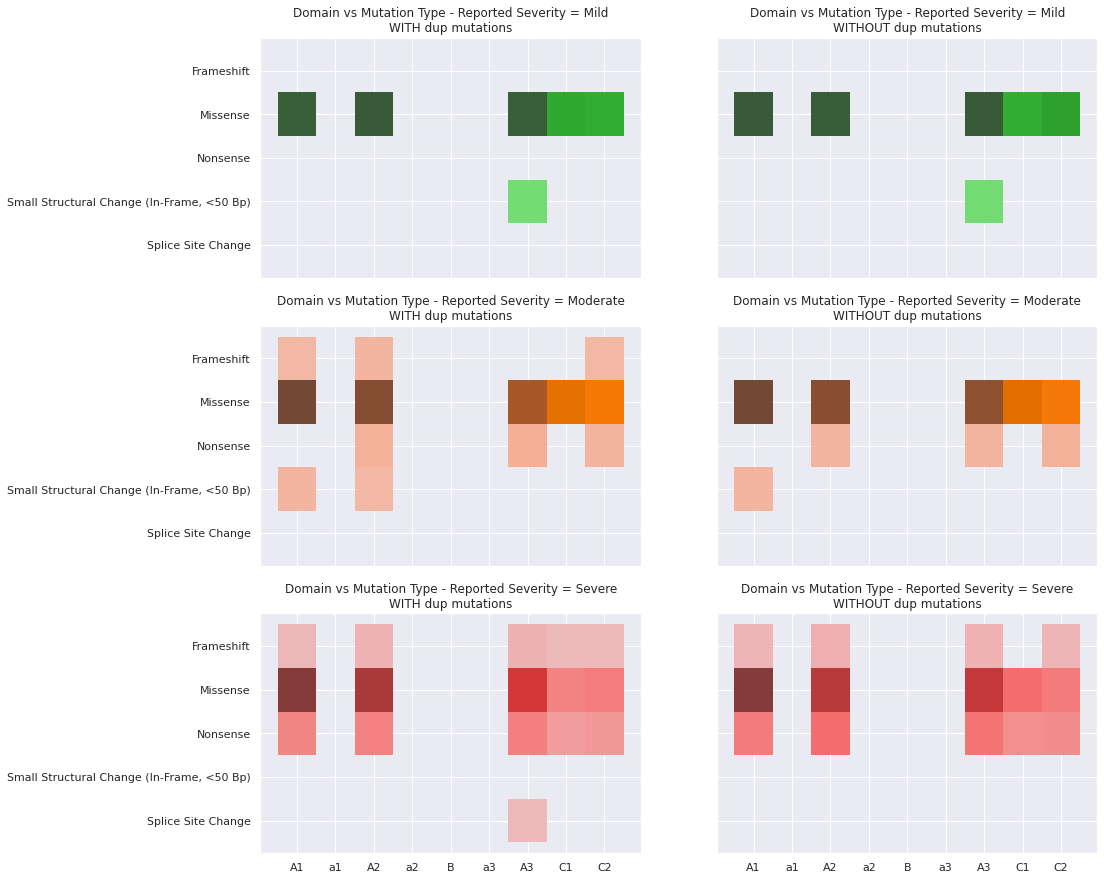

In [ ]:
histplot_two_all('Domain', 'Mutation Type', 'Reported Severity')

### Severity vs Domain vs Mechanism

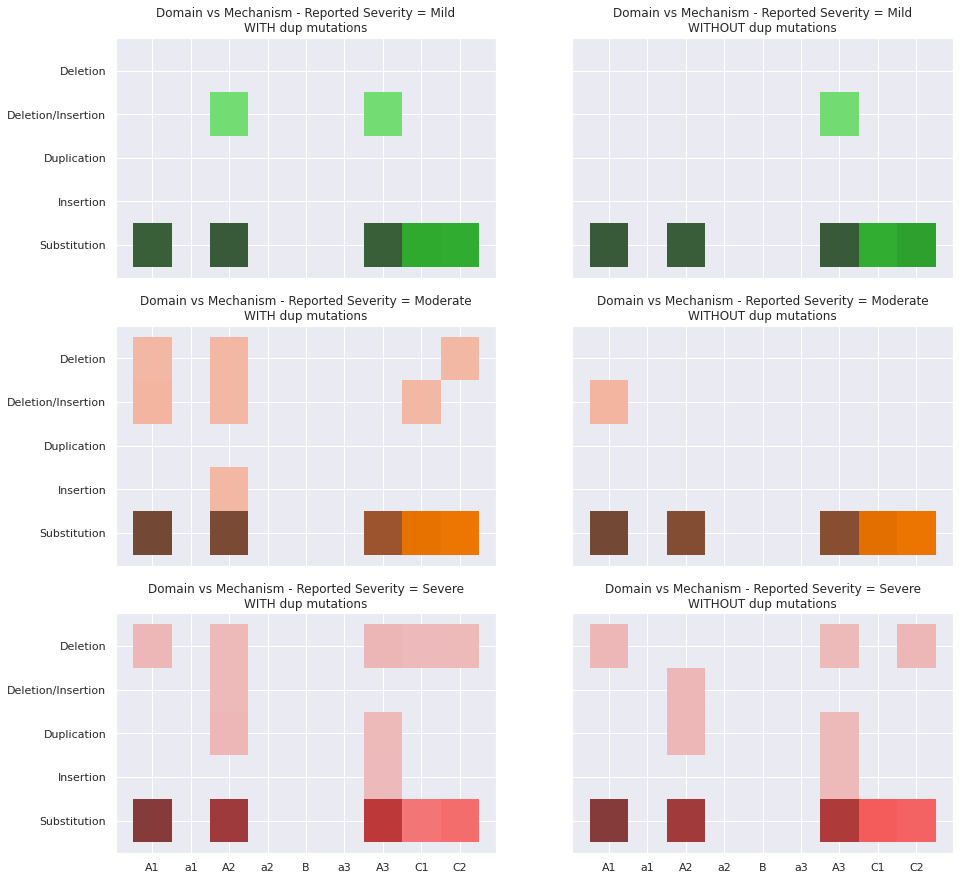

In [ ]:
histplot_two_all('Domain', 'Mechanism', 'Reported Severity')

### Inhibitors vs Mutation Type

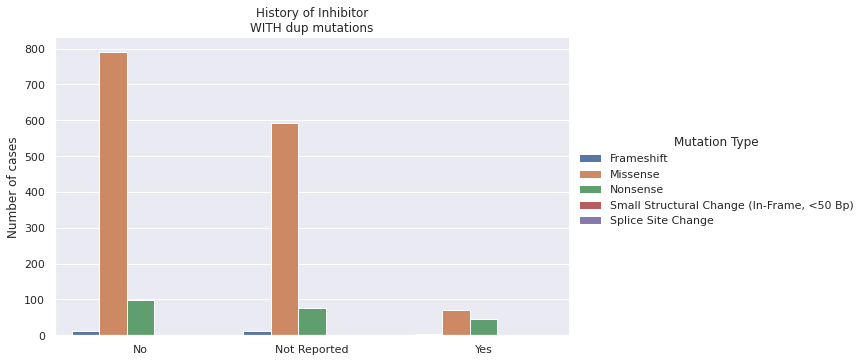

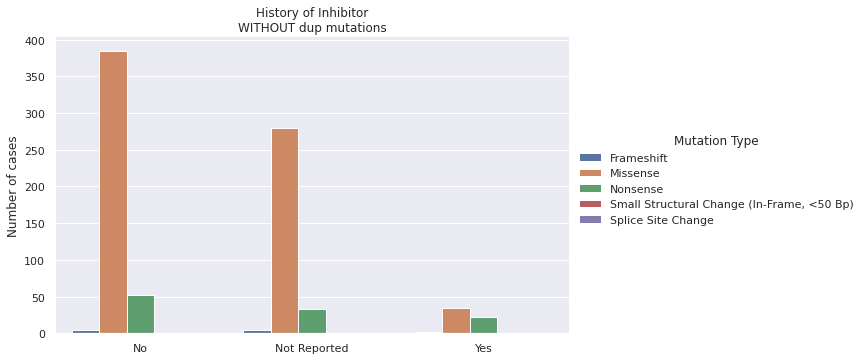

In [ ]:
catplot_custom(x='History of Inhibitor', hue='Mutation Type', has_dup=True)
catplot_custom(x='History of Inhibitor', hue='Mutation Type', has_dup=False)

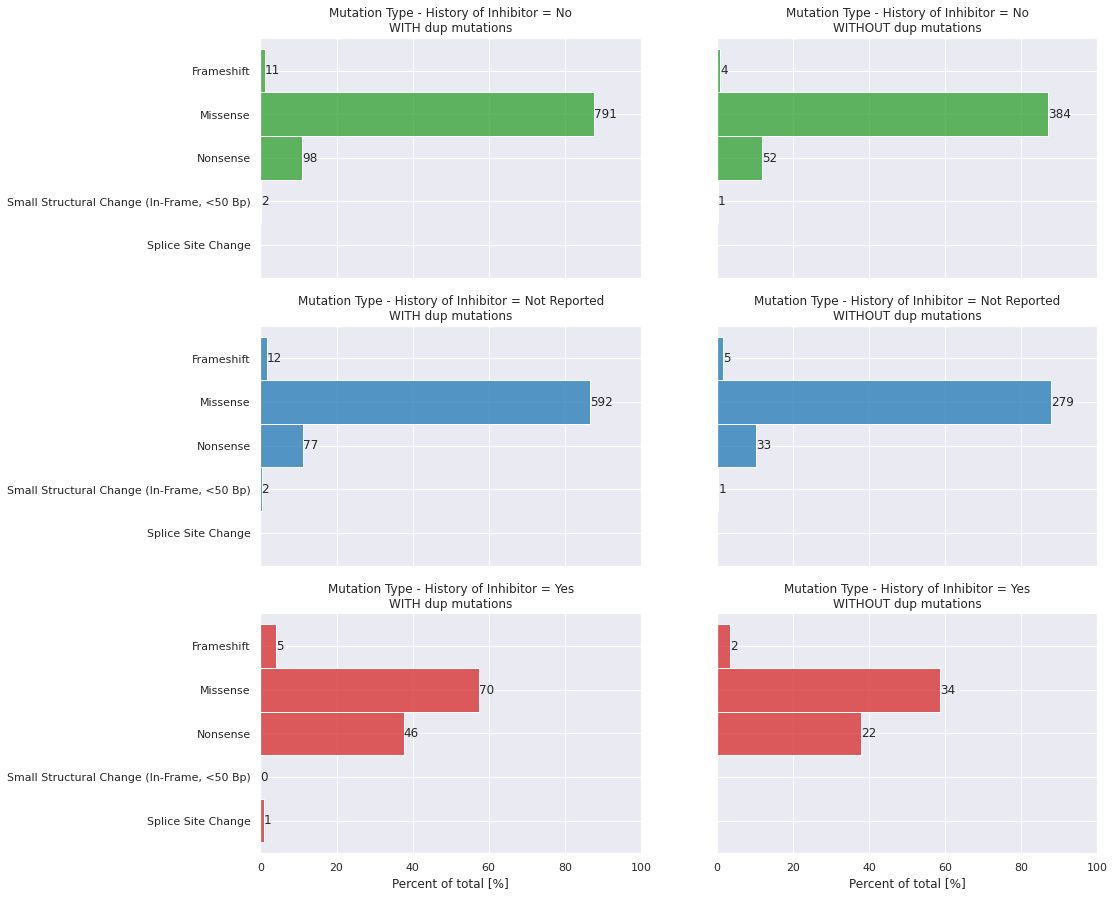



-------------------------------------------------------------



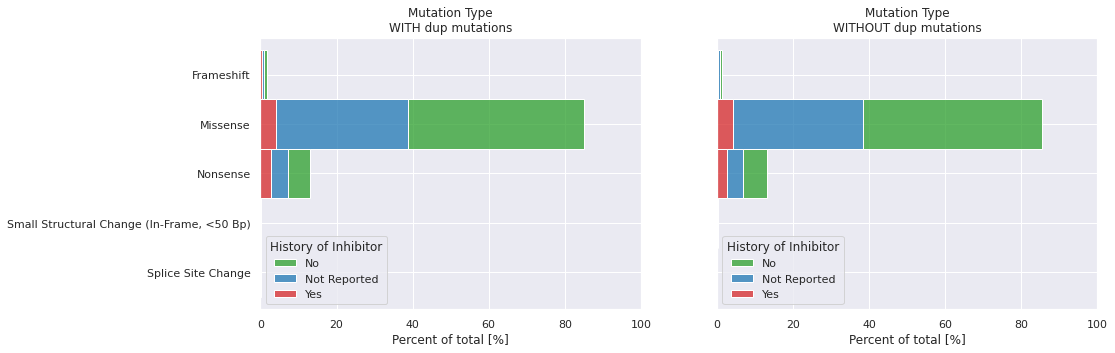

In [ ]:
histplot_one_all('Mutation Type', 'History of Inhibitor')

### Inhibitors vs Mechanism

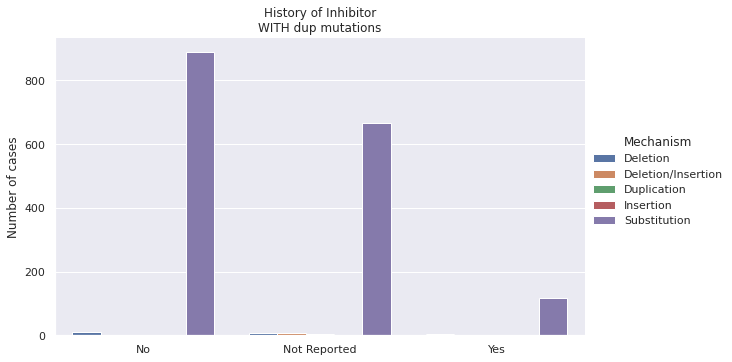

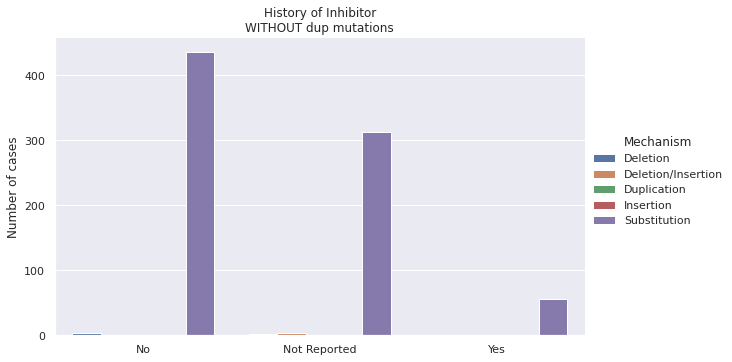

In [ ]:
catplot_custom(x='History of Inhibitor', hue='Mechanism', has_dup=True)
catplot_custom(x='History of Inhibitor', hue='Mechanism', has_dup=False)

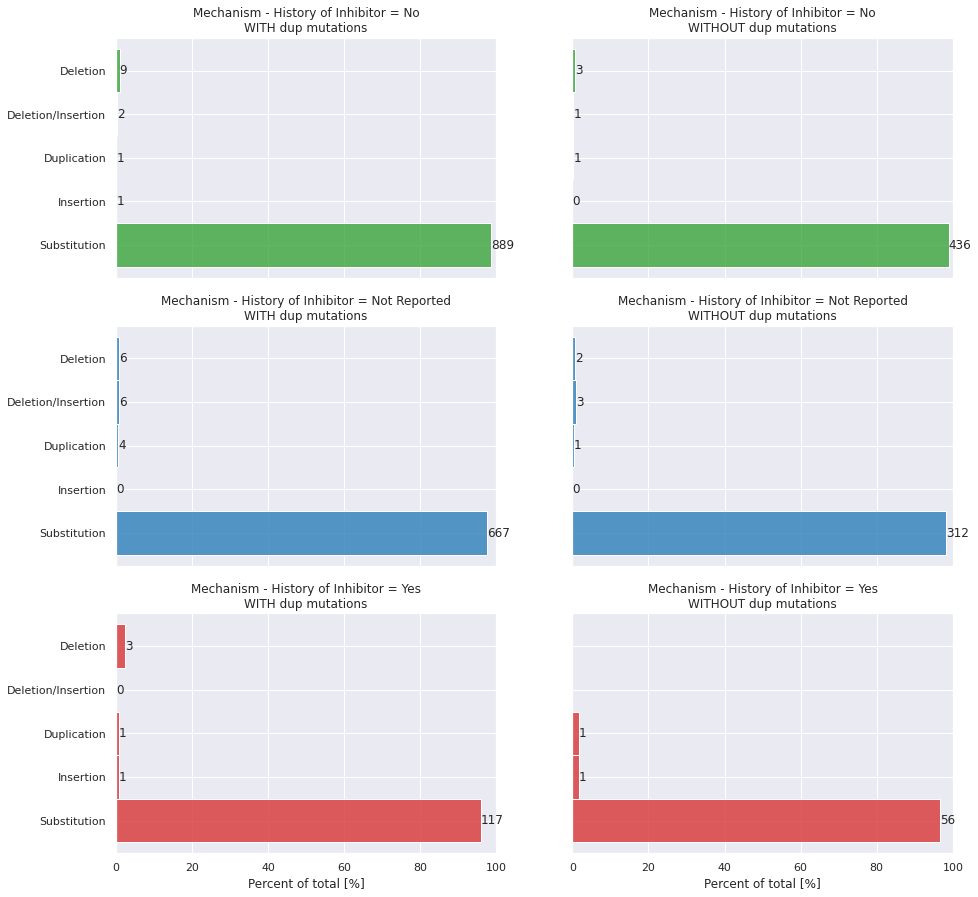



-------------------------------------------------------------



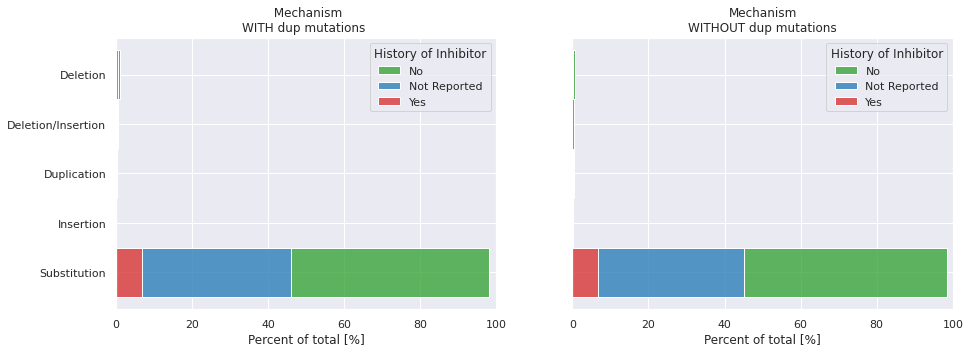

In [ ]:
histplot_one_all('Mechanism', 'History of Inhibitor')

### Inhibitors vs Domain

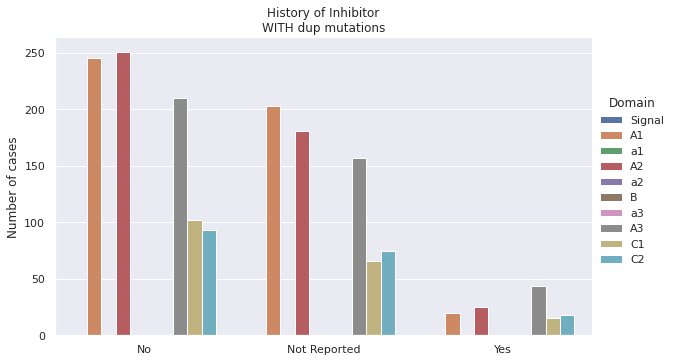

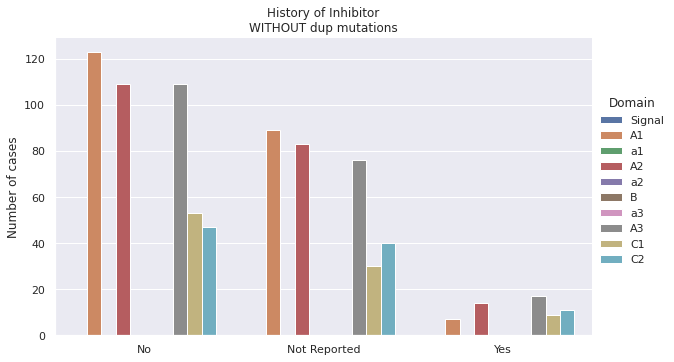

In [ ]:
catplot_custom(x='History of Inhibitor', hue='Domain', has_dup=True)
catplot_custom(x='History of Inhibitor', hue='Domain', has_dup=False)

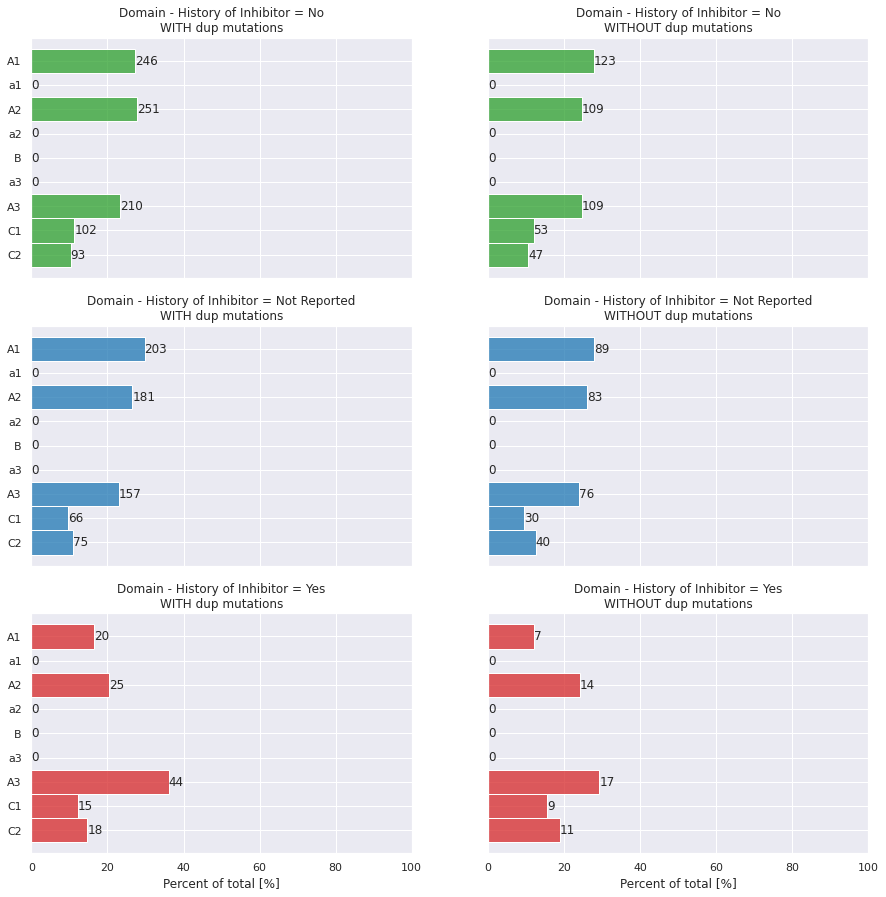



-------------------------------------------------------------



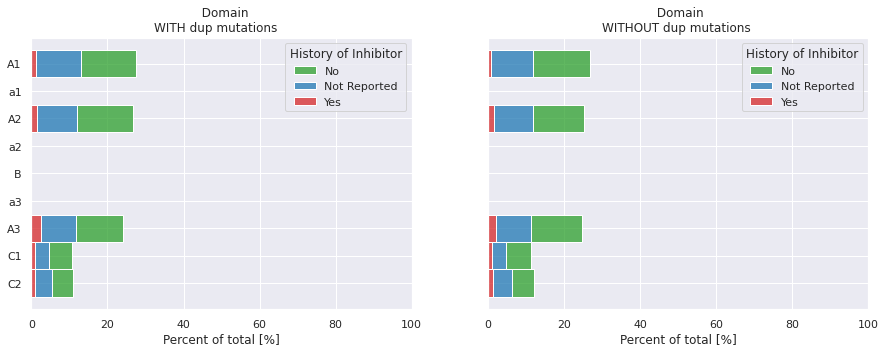

In [ ]:
histplot_one_all('Domain', 'History of Inhibitor')

### Inhibitors vs Domain vs Mutation Type

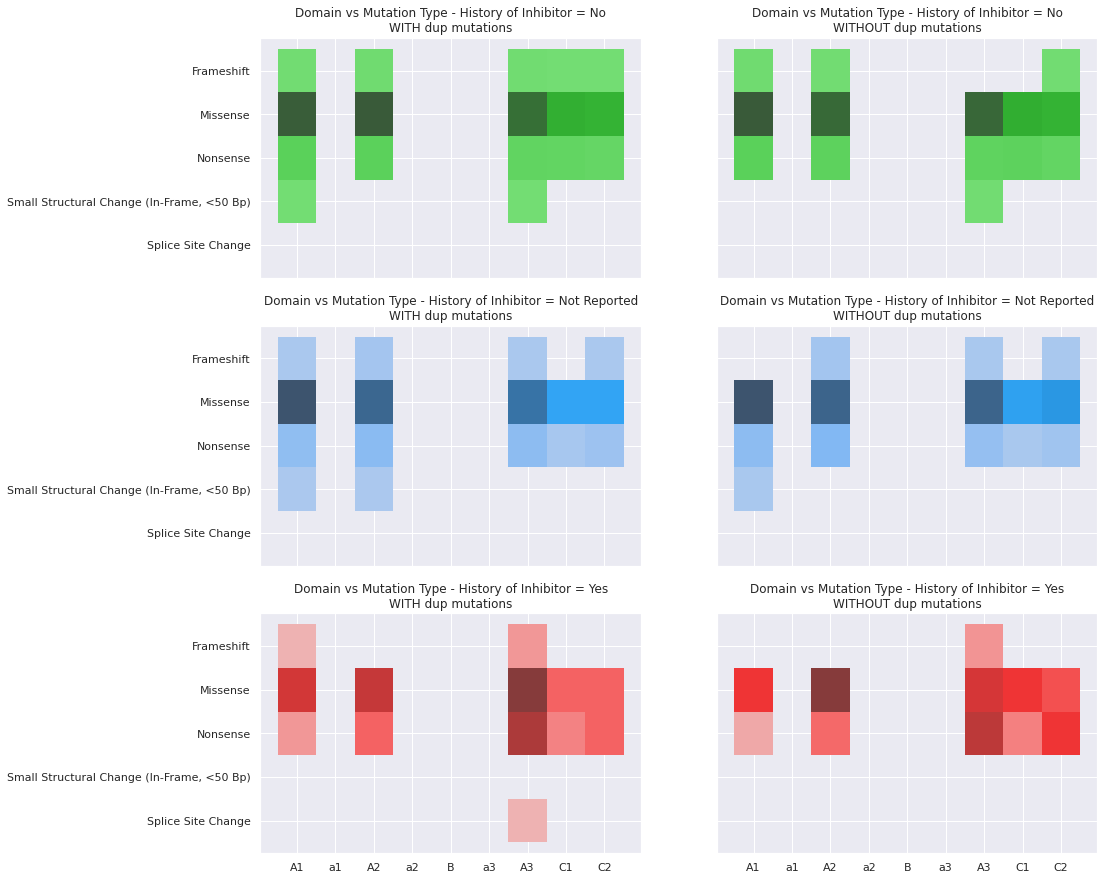

In [ ]:
histplot_two_all('Domain', 'Mutation Type', 'History of Inhibitor')

### Inhibitors vs Domain vs Mechanism

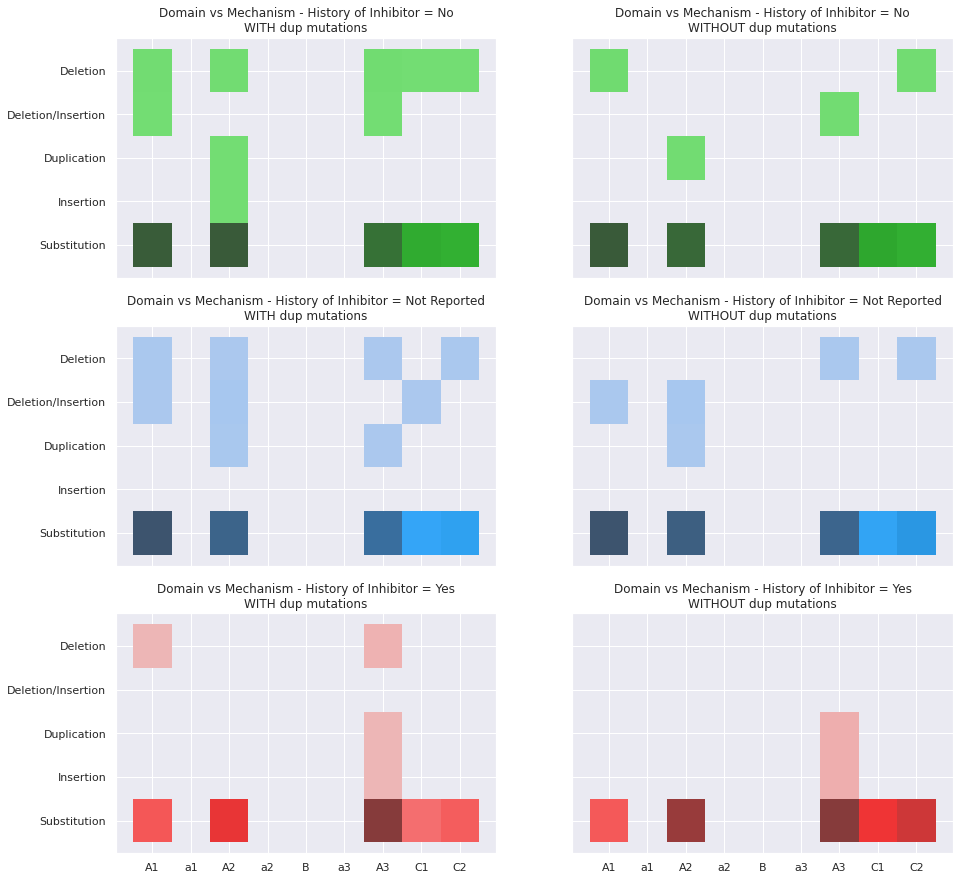

In [ ]:
histplot_two_all('Domain', 'Mechanism', 'History of Inhibitor')